#| default_exp fastai# FastAI Example

> FASTAI Example

In [ ]:
#| default_exp fastai

In [ ]:
!conda list | findstr "pytorch"

pytorch                   2.0.1           py3.11_cuda11.8_cudnn8_0    pytorch
pytorch-cuda              11.8                 h24eeafa_5    pytorch
pytorch-mutex             1.0                        cuda    pytorch


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!pip list | findstr "fastai" 

fastai                   2.7.12


In [ ]:
!pip list | findstr "duckduckgo"

duckduckgo-search        3.8.3


In [ ]:
!pip list | findstr "fastbook"

fastbook                 0.0.29


In [ ]:
from fastbook import search_images_ddg
from fastdownload import download_url
from fastai.vision.all import *

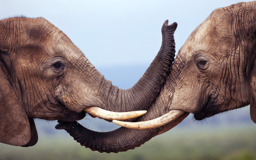

In [ ]:
download_url(search_images_ddg('elephant', max_images=2)[1], 'elephant.jpg', show_progress=False)

im = Image.open('elephant.jpg')
im.to_thumb(256,256)

In [ ]:
torch.cuda.is_available()

True